# Goodbooks-10k Recommendation Project

### Introduction

* I will be experimenting with three popular techniques that are commonly used in the Recommendation System world. These include:

    **1. Weighted-Scoring/Popularity-Based:**

    All books receive a score from 1 to 5 that takes into account their average rating and number of ratings given. Books that have a higher score are deemed more "popular" and are more likely to be recommended to the user.

    **2. Content-Based Filtering:**

    The system heavily relies on item attributes such as book summary, author, tags, date published, etc. to recommend books similar to ones the user has read already. 

    **3. Collaborative Filtering:**

    This method is based on the belief that people like things that are similar to what they already like and things that people who are similar to them also like. There are a couple types of collaborative filtering and methods to go about implementing it, but we will delve into it later on.
    

### Table of Contents:
#### 1. Data Collection
#### 2. Data Cleaning
#### 3. Exploratory Data Analysis
#### 4. Weighted-Scoring/Popularity-Based Filtering
#### 5. Content-Based Filtering
#### 6. Collaborative Filtering
#### 7. Conclusion

# 1. Data Collection


In [2]:


import random                                                              
                                                                           
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer

from IPython.display import display, HTML
import seaborn as sns
import time

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler


CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [25]:
popular_list

NameError: name 'popular_list' is not defined

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
pd.options.display.max_colwidth = 500

In [6]:
book_tags = pd.read_csv(r'../data/raw/book_tags.csv')
ratings = pd.read_csv(r'../data/raw/ratings.csv')
books = pd.read_csv(r'../data/raw/books.csv')
tags = pd.read_csv(r'../data/raw/tags.csv')

# 2. Data Cleaning

## 2.1 books

<mark>books</mark> contains 10,000 books and 23 columns listing their attributes.

- Replace *book_id* to *goodreads_book_id* to make joining tables easier 
- Replace *id* to *book_id* 
- Filter out irrelevant columns


In [7]:
display(books.columns)

Index(['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn',
       'isbn13', 'authors', 'original_publication_year', 'original_title',
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url',
       'small_image_url'],
      dtype='object')

In [5]:
display(books.head())

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780000e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg
1,2,3,3,4640799,491,439554934,9.780000e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg
2,3,41865,41865,3212258,226,316015849,9.780000e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg
3,4,2657,2657,3275794,487,61120081,9.780000e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m/2657.jpg,https://images.gr-assets.com/books/1361975680s/2657.jpg
4,5,4671,4671,245494,1356,743273567,9.780000e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m/4671.jpg,https://images.gr-assets.com/books/1490528560s/4671.jpg


In [6]:
books.columns

Index(['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn',
       'isbn13', 'authors', 'original_publication_year', 'original_title',
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url',
       'small_image_url'],
      dtype='object')

In [17]:
books_list = books[['id','title','original_title','isbn','authors','original_publication_year','ratings_count','average_rating','image_url','small_image_url']]

In [18]:
books_list.head()

,id,title,original_title,isbn,authors,original_publication_year,ratings_count,average_rating,image_url,small_image_url
0,1,"The Hunger Games (The Hunger Games, #1)",The Hunger Games,439023483,Suzanne Collins,2008.0,4780653,4.34,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,Harry Potter and the Philosopher's Stone,439554934,"J.K. Rowling, Mary GrandPré",1997.0,4602479,4.44,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,"Twilight (Twilight, #1)",Twilight,316015849,Stephenie Meyer,2005.0,3866839,3.57,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,To Kill a Mockingbird,To Kill a Mockingbird,61120081,Harper Lee,1960.0,3198671,4.25,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,The Great Gatsby,The Great Gatsby,743273567,F. Scott Fitzgerald,1925.0,2683664,3.89,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [19]:
# filter out columns 
books_cleaned = books[['id','book_id','title','average_rating','work_ratings_count','original_publication_year']].rename(columns={'book_id' : 'goodreads_book_id', 'id' : 'book_id'})
display(books_cleaned);

,book_id,goodreads_book_id,title,average_rating,work_ratings_count,original_publication_year
0,1,2767052,"The Hunger Games (The Hunger Games, #1)",4.34,4942365,2008.0
1,2,3,Harry Potter and the Sorcerer's Stone (Harry P...,4.44,4800065,1997.0
2,3,41865,"Twilight (Twilight, #1)",3.57,3916824,2005.0
3,4,2657,To Kill a Mockingbird,4.25,3340896,1960.0
4,5,4671,The Great Gatsby,3.89,2773745,1925.0
...,...,...,...,...,...,...
9995,9996,7130616,"Bayou Moon (The Edge, #2)",4.09,18856,2010.0
9996,9997,208324,"Means of Ascent (The Years of Lyndon Johnson, #2)",4.25,12952,1990.0
9997,9998,77431,The Mauritius Command,4.35,10733,1977.0
9998,9999,8565083,Cinderella Ate My Daughter: Dispatches from th...,3.65,11994,2011.0


## 2.2 *tags* and *book_tags*

Every book is given multiple tags set by various users. These tags could be the author, genre, or any other aspect of the book. The table ***tags*** maps each tag_id to its string representation and the table ***book_tags*** lists every book, their tags, and tag counts. These tables are key to implementing our content-based filtering algorithm.

**Cleaning *book_tags* and *tags***

- Combine the tables on *tag_id*
- Filter top 30 tags per book (ranked by number of times book was tagged by tag) to save space
- Add a column containing the book title 

**In order to make sure TfidVectorizer works properly, we have to clean the tag names**

- Standardize letters to lowercase 
- Replace all punctuation with spaces 
- Trim white spaces

In [10]:
# Here are the raw book_tags and tags tables
display(book_tags)
display(tags)

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716
...,...,...,...
999907,33288638,21303,7
999908,33288638,17271,7
999909,33288638,1126,7
999910,33288638,11478,7


,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-
...,...,...
34247,34247,Ｃhildrens
34248,34248,Ｆａｖｏｒｉｔｅｓ
34249,34249,Ｍａｎｇａ
34250,34250,ＳＥＲＩＥＳ


In [11]:
# add book_id to book_tags 
book_tags = book_tags.merge(books_cleaned[['book_id','goodreads_book_id']],on='goodreads_book_id')

# remove punctuation from tags
punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '

# standardize letters to lowercase letters, replace all punctuation with spaces, trim white spaces
tags["tag_name"] = tags['tag_name'].str.replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ]',' ').map(lambda x: x.lower().strip())

# merge tags and book_tags
book_tags_cleaned = book_tags.merge(tags, on=['tag_id'])
# filter top 20 tags for each book
book_tags_cleaned = book_tags_cleaned.groupby(['book_id']).head(30)
# Add column: collection of tags associated with each book
book_tags_cleaned['tags'] = book_tags_cleaned.groupby(['book_id'])['tag_name'].transform(lambda x: ' '.join(x))
# drop duplicates
book_tags_cleaned = book_tags_cleaned[['book_id','tags']].drop_duplicates()
# Add column: book title
book_tags_cleaned = book_tags_cleaned.merge(books_cleaned[['book_id','title']],on=['book_id'])
# test
display(book_tags_cleaned)

,book_id,tags,title
0,27,to read fantasy favorites currently reading yo...,Harry Potter and the Half-Blood Prince (Harry ...
1,21,to read fantasy favorites currently reading yo...,Harry Potter and the Order of the Phoenix (Har...
2,2,to read fantasy favorites currently reading yo...,Harry Potter and the Sorcerer's Stone (Harry P...
3,18,to read fantasy favorites currently reading yo...,Harry Potter and the Prisoner of Azkaban (Harr...
4,24,to read fantasy young adult fiction harry pott...,Harry Potter and the Goblet of Fire (Harry Pot...
...,...,...,...
9995,8166,favorites currently reading fiction books i ow...,Among the Ten Thousand Things
9996,6281,favorites books i own owned series owned books...,"The English Spy (Gabriel Allon, #15)"
9997,9945,currently reading books i own owned series fav...,"Rock Bottom (Tristan & Danika, #2)"
9998,756,owned ya series favourites owned books re read...,"The Iron King (The Iron Fey, #1)"


**Here are the most popular tags.**

In [12]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(' '.join(book_tags_cleaned['tags']))


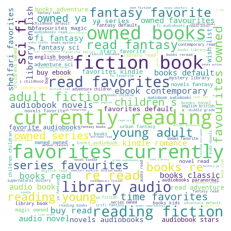

In [13]:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

It seems that the most popular tags are 'currently-reading' and 'favorites currently' which are applicable to numerous books. We can also see that the most popular genres include 'fiction', 'adult fiction', 'sci fi', fantasy', and 'children'.

In [12]:
book_tags_cleaned.head()

,book_id,tags,title
0,27,to read fantasy favorites currently reading yo...,Harry Potter and the Half-Blood Prince (Harry ...
1,21,to read fantasy favorites currently reading yo...,Harry Potter and the Order of the Phoenix (Har...
2,2,to read fantasy favorites currently reading yo...,Harry Potter and the Sorcerer's Stone (Harry P...
3,18,to read fantasy favorites currently reading yo...,Harry Potter and the Prisoner of Azkaban (Harr...
4,24,to read fantasy young adult fiction harry pott...,Harry Potter and the Goblet of Fire (Harry Pot...


In [37]:
indices = pd.Series(book_tags_cleaned['book_id'].values,index=book_tags_cleaned['title'])
indices

title
Harry Potter and the Half-Blood Prince (Harry Potter, #6)         27
Harry Potter and the Order of the Phoenix (Harry Potter, #5)      21
Harry Potter and the Sorcerer's Stone (Harry Potter, #1)           2
Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)       18
Harry Potter and the Goblet of Fire (Harry Potter, #4)            24
                                                                ... 
Among the Ten Thousand Things                                   8166
The English Spy (Gabriel Allon, #15)                            6281
Rock Bottom (Tristan & Danika, #2)                              9945
The Iron King (The Iron Fey, #1)                                 756
Book of Shadows (Sweep, #1)                                     7387
Length: 10000, dtype: int64

In [50]:
book_tags_cleaned['title'].values.tolist()

['Harry Potter and the Half-Blood Prince (Harry Potter, #6)',
 'Harry Potter and the Order of the Phoenix (Harry Potter, #5)',
 "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",
 'Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)',
 'Harry Potter and the Goblet of Fire (Harry Potter, #4)',
 'Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)',
 'Harry Potter Collection (Harry Potter, #1-6)',
 "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)",
 "The Ultimate Hitchhiker's Guide to the Galaxy",
 'A Short History of Nearly Everything',
 'In a Sunburned Country',
 "I'm a Stranger Here Myself: Notes on Returning to America after Twenty Years Away",
 'The Lost Continent: Travels in Small Town America',
 'Neither Here nor There: Travels in Europe',
 'Notes from a Small Island',
 'The Mother Tongue: English and How It Got That Way',
 'J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings',
 'The Lord of the Rings (The Lord of t

In [23]:
books_list = book_tags_cleaned[['title']].merge(books_list, how='left',on='title').sort_values('id')
books_list.to_csv('../data/processed/books_list.csv',index=False)

In [25]:
books_list.set_index('id')

,title,original_title,isbn,authors,original_publication_year,ratings_count,average_rating,image_url,small_image_url
id,,,,,,,,,
1,"The Hunger Games (The Hunger Games, #1)",The Hunger Games,439023483,Suzanne Collins,2008.0,4780653,4.34,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
2,Harry Potter and the Sorcerer's Stone (Harry P...,Harry Potter and the Philosopher's Stone,439554934,"J.K. Rowling, Mary GrandPré",1997.0,4602479,4.44,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
3,"Twilight (Twilight, #1)",Twilight,316015849,Stephenie Meyer,2005.0,3866839,3.57,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
4,To Kill a Mockingbird,To Kill a Mockingbird,61120081,Harper Lee,1960.0,3198671,4.25,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
5,The Great Gatsby,The Great Gatsby,743273567,F. Scott Fitzgerald,1925.0,2683664,3.89,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...
9996,"Bayou Moon (The Edge, #2)",Bayou Moon,441019455,Ilona Andrews,2010.0,17204,4.09,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...
9997,"Means of Ascent (The Years of Lyndon Johnson, #2)",Means of Ascent,067973371X,Robert A. Caro,1990.0,12582,4.25,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9998,The Mauritius Command,The Mauritius Command,039330762X,Patrick O'Brian,1977.0,9421,4.35,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...


## 2.3 *ratings*

***ratings*** contains all the ratings given from any user. 

- Include only the last rating a user gave to a book since some books were rated multiple times

In [15]:
ratings_cleaned = ratings.groupby(by=['user_id', 'book_id']).last().reset_index()

Although there are a large number of users and books, the vast majority of people have only rated a few number of books. In an effort to reduce space we will filter out the majority of ratings. Let's look at the ***ratings*** statistics for all the users in the system and compare the information to a random 30%* of the population and also the top 30%* of users who have given the most ratings. 


*These percentages were chosen arbitrarily.

In [16]:
# all users
all_ratings_count = ratings_cleaned.groupby('user_id').agg('count')[['book_id']].rename(columns={'book_id': 'all_users_rating'})
display(all_ratings_count.describe())

# random 30%
thirty_users = ratings_cleaned.groupby('user_id').agg('count').reset_index().sample(frac=.3,random_state=42)['user_id']
ratings_30 = ratings_cleaned[ratings_cleaned['user_id'].isin(thirty_users)]
num_ratings_per_30_user = ratings_30.groupby('user_id').agg('count')[['book_id']].rename(columns={'book_id': 'random_users_rating'})
display(num_ratings_per_30_user.describe())

# top 30% of users who have most ratings
all_users_ordered = ratings_cleaned.groupby('user_id').agg('count').reset_index().sort_values('book_id',ascending=False)
top_users = all_users_ordered.head(int(len(all_users_ordered)*.30))['user_id']
ratings_top_users = ratings_cleaned[ratings_cleaned['user_id'].isin(top_users)].merge(books_cleaned[['title','book_id']], on='book_id',how='left')
num_ratings_per_top_user = ratings_top_users.groupby('user_id').agg('count')[['book_id']].rename(columns={'book_id': 'top_users_rating'})

display(num_ratings_per_top_user.describe())

,all_users_rating
count,53424.000000
mean,18.334045
std,26.224647
min,1.000000
25%,3.000000
50%,8.000000
75%,22.000000
max,200.000000


,random_users_rating
count,16027.000000
mean,18.494540
std,26.250448
min,1.000000
25%,3.000000
50%,8.000000
75%,22.000000
max,197.000000


,top_users_rating
count,16027.000000
mean,46.567417
std,33.332634
min,17.000000
25%,24.000000
50%,35.000000
75%,56.000000
max,200.000000


The count for each table represents the number of users taken into consideration. The first table includes all ratings accounted for from 53424 users. The second table includes a random 30% of ratings from 16027 users. The third table includes the top 30% of users who rated the most books and there are also 16027 users.


**How many ratings does each person tend to give?**

As you can see, the mean number of ratings each person gives is about 18. This is true for the entire population and the random subset. But, the top 25% of users who give the most ratings has an average of 52 ratings per user.

In [17]:
ratings_count = ratings_cleaned.groupby('rating').agg('count').reset_index()[['rating','book_id']]
ratings_count = ratings_count.rename(columns={'book_id': 'all_percentage'})

ratings_top_users_count = ratings_top_users.groupby('rating').agg('count').reset_index()[['rating','book_id']]
ratings_top_users_count = ratings_top_users_count.rename(columns={'book_id': 'top_percentage'})

ratings_30_count = ratings_30.groupby('rating').agg('count').reset_index()[['rating','book_id']]
ratings_30_count = ratings_30_count.rename(columns={'book_id': 'random_percentage'})

combined_ratings = pd.merge(pd.merge(ratings_count,ratings_top_users_count,on='rating'),ratings_30_count,on='rating').set_index('rating')

combined_ratings_percentage = (100. * combined_ratings / combined_ratings.sum())

combined_ratings.loc['Column_Total']= combined_ratings.sum(numeric_only=True, axis=0)
combined_ratings


,all_percentage,top_percentage,random_percentage
rating,,,
1,19529,14716,5746
2,63124,48468,18507
3,248170,191213,74831
4,356607,272231,108073
5,292048,219708,89255
Column_Total,979478,746336,296412


,all_percentage,top_percentage,random_percentage
rating,,,
1,1.993817,1.971766,1.938518
2,6.444657,6.494126,6.243674
3,25.336965,25.620230,25.245604
4,36.407862,36.475662,36.460400
5,29.816698,29.438215,30.111804


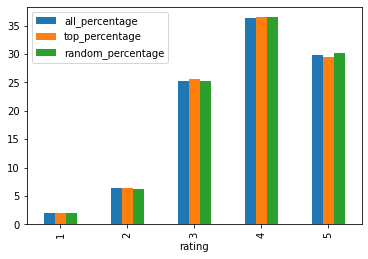

In [18]:
display(combined_ratings_percentage)

combined_ratings_percentage.reset_index().plot(x="rating", y=["all_percentage", "top_percentage", "random_percentage"], kind="bar");

This table represents the distribution of ratings (from 1-5) for all of our samples. For example, approximately 1.99% of all users gave a rating of 1 to a book. In comparison, 1.96% of our random subset of 30% gave a rating of 1 and 1.94% of the top 30% of users gave a rating of 1.


**In general, do users who rate more often rate differently from those who don't?**

No. The distribution of ratings is almost the same for all three samples. These users do not behave differently from the rest of the population. So, in an effort to save space but still maintain the best results, we will choose the 30% subset to represent the ratings.

In [19]:
ratings_cleaned = ratings_top_users
ratings_cleaned.describe()

,user_id,book_id,rating
count,746336.000000,746336.000000,746336.000000
mean,25247.236282,4262.333722,3.849144
std,15139.226756,2749.379049,0.982371
min,7.000000,1.000000,1.000000
25%,12063.000000,1899.000000,3.000000
50%,24499.000000,3956.000000,4.000000
75%,37964.000000,6423.000000,5.000000
max,53422.000000,10000.000000,5.000000


In [20]:
books_cleaned.to_csv('books_cleaned.csv',index=False)
book_tags_cleaned.to_csv('book_tags_cleaned.csv',index=False)
ratings_cleaned.to_csv('ratings_cleaned.csv',index=False)


## 3. Exploratory Data Analysis

**Is there a relationship between the year a book was published and the average rating it got?**

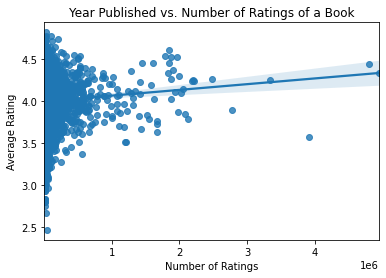

In [21]:
ax = sns.regplot(data=books_cleaned, x="work_ratings_count", y="average_rating")
ax.set(xlabel='Number of Ratings', ylabel='Average Rating', title='Year Published vs. Number of Ratings of a Book')
plt.show(ax)

There is a positive correlation between the number of ratings and average rating. Books that are very popular seem to have a higher average rating.

**Is there a relationship between the year a book was published and the number of ratings it got?**

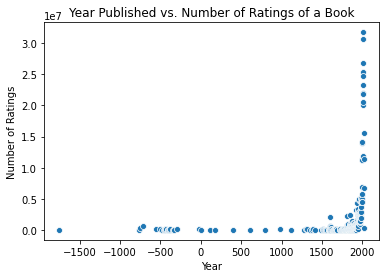

In [22]:
books_year_avg_ratings = books_cleaned.groupby('original_publication_year').agg(sum).reset_index()[['original_publication_year','work_ratings_count']]
ax = sns.scatterplot(data=books_year_avg_ratings, x="original_publication_year", y="work_ratings_count")
ax.set(xlabel='Year', ylabel='Number of Ratings', title='Year Published vs. Number of Ratings of a Book')
plt.show(ax)

Books that were published closer to the present year received an overwhelmingly large portion of total ratings.

**Is there a relationship between the book title length and the number of ratings it received?**

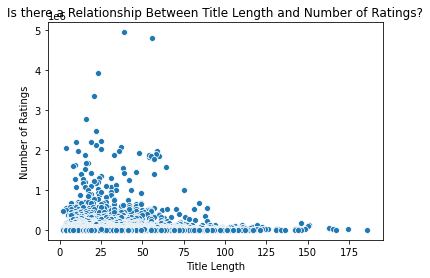

In [23]:
books_cleaned['title_length']  = books_cleaned['title'].str.len()
ax = sns.scatterplot(data=books_cleaned, x="title_length", y="work_ratings_count")
ax.set(xlabel='Title Length', ylabel='Number of Ratings', title='Is there a Relationship Between Title Length and Number of Ratings?')
plt.show(ax)

#  **4. Popularity-Based Filtering**

### 4.1 Description

Popularity Based Filtering is a recommendation system that suggests the most "popular" items. User preferences are not taken into account; instead, recommendations are based on a ranking or score that utilizes item attributes (i.e. watch time, ratings, number of purchases). It is important to note that this algorithm recommends the same content to every consumer. Some examples of this type of system include the Youtube Trending and Twitter News.

### 4.2 Pros and Cons

#### Pros:
 - Fixes cold start issues: If a user is a new user who has limited to no history, recommending trending products (as opposed to a random assortment) increases the chance of the user clicking on or purchasing products.
 
- Easy to code: Doesn't require complex algorithms to implement. 

#### Cons:
 - Not Personalized: Every user is being offered the same products. This method takes no consideration  what the customer's tastes and preferences are.

### 4.3 Methodology
   For this project, popularity is based on a weighted ranking formula that considers a book's average rating, total number of votes, mean rating across the dataset, and minimum number of votes for the book to be listed in the top 10% of books. Books with a high rating but small number of reviews are ranked lower than books with a slighly lower rating but large number of reviews. Likewise, books with a low rating but high number of reviews are ranked higher than books with a slightly higher rating but low number of reviews.

### Weighted Ranking Formula
This is the formula we will use to determine which books are the most "popular".


$$ W = \frac{Rv + Cm}{v + m} $$
where:

W: Weighted Ranking for particular book

R: Average rating (out of 5) for book

v: Number of votes for book

C: Mean vote across dataset

m: Minimum number of votes for book to be listed in the 10% books

In [29]:
# compute weighted ranking scores for each book

r = books_cleaned['average_rating'] # average rating per book
v = books_cleaned['work_ratings_count'] # number of ratings per book
c = books_cleaned['average_rating'].mean() # average rating across entire dataset
m = books_cleaned['work_ratings_count'].quantile(.90) # top 10% of books with the most ratings

books_weighted_ranking = books_cleaned[['book_id','title','average_rating','work_ratings_count']].copy()
books_weighted_ranking['weighted_score'] = (r*v + c*m) / (v+m)

In [30]:
books_weighted_ranking[0:3]

,book_id,title,average_rating,work_ratings_count,weighted_score
0,1,"The Hunger Games (The Hunger Games, #1)",4.34,4942365,4.333032
1,2,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",4.44,4800065,4.430707
2,3,"Twilight (Twilight, #1)",3.57,3916824,3.581189


In [31]:
# create table that sorts books based on ranking
books_weighted_ranking = books_weighted_ranking.sort_values(by=['weighted_score'], ascending=False)

In [32]:
# function that returns most popular books

def popular_rec(num_books):
    return books_weighted_ranking[['title']][0:num_books]
popular_rec(10)

,title
24,"Harry Potter and the Deathly Hallows (Harry Potter, #7)"
26,"Harry Potter and the Half-Blood Prince (Harry Potter, #6)"
17,"Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)"
23,"Harry Potter and the Goblet of Fire (Harry Potter, #4)"
421,"Harry Potter Boxset (Harry Potter, #1-7)"
134,"A Storm of Swords (A Song of Ice and Fire, #3)"
191,"The Name of the Wind (The Kingkiller Chronicle, #1)"
20,"Harry Potter and the Order of the Phoenix (Harry Potter, #5)"
1,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)"
160,"The Return of the King (The Lord of the Rings, #3)"


In [33]:
popular_list = popular_rec(len(books_cleaned))
popular_list

,title
24,"Harry Potter and the Deathly Hallows (Harry Potter, #7)"
26,"Harry Potter and the Half-Blood Prince (Harry Potter, #6)"
17,"Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)"
23,"Harry Potter and the Goblet of Fire (Harry Potter, #4)"
421,"Harry Potter Boxset (Harry Potter, #1-7)"
...,...
39,"Eat, Pray, Love"
227,"The Nanny Diaries (Nanny, #1)"
1792,One Night at the Call Center
341,The Casual Vacancy


In [ ]:
popular_list = popular_list.merge(books_pkl,how='inner',left_on='title',right_on='title')
popular_list.head()

In [ ]:
books_pkl.head()

In [ ]:
popular_list.to_csv('popular_list.csv',index=False)

In [ ]:
import matplotlib.pyplot as plt

# plots top 10 most popular books

fig, ax = plt.subplots()
most_popular_books = books_weighted_ranking[0:10]
ax.barh(most_popular_books['title'],most_popular_books['weighted_score'],align='center')
ax.set_xlabel('Weighted Score')
ax.set_ylabel('Book Title')
ax.set_title('Most Popular Books')
ax.invert_yaxis() 
plt.show()

In [ ]:
import pickle
pickle_out = open("popular.pkl","wb")
pickle.dump(popular_rec,pickle_out)
pickle_out.close()


In [ ]:
pickle.dump(popular_rec)

In [ ]:
pop_ser = pickle.dumps(popular_rec)
pop_ser

In [ ]:
id2 = pickle.loads(pop_ser)
id2(2)

In [ ]:
book_tags_cleaned

In [ ]:
popular_list = pd.read_csv('popular_list.csv')
popular_list

# 5. Content-Based Filtering


### 5.1 Description
This method recommends products similar to what the user has purchased/clicked on. Examples include recommending Apple products when purchasing an iPhone case online or recommending books from authors with similar writing style. Item attributes (i.e. keywords, description, author, genre, etc.) are utilized to recommend products similar to what the user has purchased/used/clicked on in the past. 


### 5.2 Pros and Cons

#### Pros:
- Does not suffer from a cold start: Even if a new user has never purchased a product before, if their profile contains genres they are interested in, content-based filtering will still be useful to implement

#### Cons:
- Item attributes are key: If there is not a good amount of item data, then this method will not be as good of a predictor

### 5.3 Methodology

The feature used in this section is tags. The tags table consists of 34253 possible unique tags that can be assigned to a book. The book_tags table lists out the top 100 tags associated with each book and their count. Only the top 30 tags (based on count) for each book will be accounted for.

TfidfVectorizer (Term Frequency and Inverse Document Frequency Vectorizor) and cosine_similarity are used to compute similarity scores for each book.


### 5.5 TFIDFVectorizor

TfidfVectorizer determines how relevant a word is to the given book's tag list within the entire tag list for each book. In order to compute the TF-IDF value (for each word-book combination), two metrics are multiplied toegether: (1) how often a word occurs in a tag-list and (2) the inverse document frequency of the word across the entire collection of tag lists.

The TFIDF value increases proportionally to the number of times a word appears in the tag list for the book in question. The TFIDF value decreases when a word is commonly found in other tag lists, alluding to the conclusion that the word is not important to that book in particular.

#### **Term Frequency**
The higher the term frequency, the more times the word is found in that specific tag list. The lower the term frequency, the less times the word is found in that specific tag list. 
$$ TF = \frac{a}{b} $$
where:

TF = Term Frequency

a = Number of times word is included in the tag list

b = Number of words in tag list (could be more than 30 if a tag is comprised of more than one word)

#### **Inverse Document Frequency**
Measures how common or rare a word is across every tag list. The closer this value is to 0, the more common a word is; the closer this value is to 1, the less common a word is.
$$ IDF = log(\frac{c}{d})$$
where:

IDF = Inverse Document Frequency (IDF)

c = Number of books

d = Number of books containing specific word

#### TF-IDF Score
The higher the score, the more descriptive the word is for that specific book. The lower the score, the less descriptive the word is for that specific book. Although some tags were prevalent in all genres of books, the cool thing about TF-IDF is that it won't rely heavily on those popular words to determine how similar books are. The more popular a tag is, the less descriptive it is to an individual book.

In [ ]:
tfv = TfidfVectorizer(analyzer='word',stop_words='english',strip_accents='unicode',ngram_range=(1,2),min_df=.05)
# ,ngram_range=(1,3) reduced from 13681 to 391
tfv_matrix = tfv.fit_transform(book_tags_cleaned['tags'])
tfv_matrix.shape

There are 10,000 books and 3865 unique tags. Here is what the string of tags looks like for some of the books.

In [ ]:
tfv_matrix.todense()

#### 5.6 Cosine Similarity

Now that we are able to numerically represent a book through its tags, we need to figure out how similar each book is to one another. We do this by calculating their cosine similarity. 

Mathematically, Cosine similarity is a metric that measures the cosine of the angle between two vectors projected in a multi-dimensional space. In our case, each vector represents all of the TF-IDF scores of each word for a given book. The cosine similarity score between two books measures how similar they are to each other. 

#### Why cosine distance?
The cosine simiilarity takes into account the direction of the books and not the magnitude. Even if one book is better described as "action" than another, despite both having a low "romance" score, our algorithm should still recommend both books to the user if they prefer action. These two points have a large Euclidean distance, but their cosine distance is relatively small, so they are deemed more similar.  

Let's say the TF-IDF score for the word "comedy" for book A is 5 and the score for book B is 4. This means that book A is slightly more comedic than book B. If user 1 has read book A, then the recommendation system has a high chance of recommending book B. Let's say book C has a comedy score of 1, then the recommendation system will not recommend book C to user 1.

![](https://miro.medium.com/max/500/1*tJ12OM8W4WX2J5Lu1J2EMg.png)


![](https://dh2016.adho.org/abstracts/static/data/290/10000201000007AF000007CFCCC81279FE2EA7FD.png)

In [ ]:
book_tags_cleaned.to_csv('book_tags_cleaned.csv',index=False)

In [ ]:
tuple('Har')

In [ ]:
books_pkl.iloc[:,1].values.tolist()

#### sklearn.metrics.pairwise cosine_similarity

cosine_similarity looks at the TFIDF vector for each word for each book and gives a score between 0 and 1 to every combination of books. The closer the cosine_similarity score is to 1, the more similar those pair of books are.

In [ ]:
book_tags_cleaned = pd.read_csv('book_tags_cleaned.csv')
book_tags_cleaned

In [ ]:
from numpy import savetxt
savetxt('tfv_matrix.csv', tfv_matrix[:5000].toarray())

In [ ]:
tfv_matrix[0]

In [ ]:
np.savetxt("tfv_matrix.csv", tfv_matrix.todense(), delimiter=",")

In [ ]:
with open('test.csv', 'w') as f:
    writer = csv.writer(f)
    for (n, m), val in np.ndenumerate(tfv_matrix):
        writer.writerow([n, m, val])

In [ ]:
type(tfv_matrix[:5000].toarray())

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Computing the cosine similarity matrix
cosine_sim = cosine_similarity(tfv_matrix[:1000], tfv_matrix[:1000])

In [ ]:
indices = pd.Series(book_tags_cleaned.index,index=book_tags_cleaned['title'])

def content_based_rec(title,sig=cosine_sim):
    book_index = indices[title]
    sorted_scores = sorted(list(enumerate(sig[indices[book_index]])),key=lambda x: x[1],reverse=True)[1:11]
    return book_tags_cleaned.iloc[[i[0] for i in sorted_scores],2]                  
    

In [ ]:
content_based_rec('Among the Ten Thousand Things')

In [ ]:
content_based_rec('Harry Potter and the Half-Blood Prince (Harry Potter, #6)')

Let's test out the content-based filtering method on these books. The top book recommended is the most similar to the book given in terms of tags and so on.

In [ ]:
content_based_rec('Ella Enchanted')

In [ ]:
content_based_rec('Harry Potter and the Half-Blood Prince (Harry Potter, #6)').index.values

# 6. Collaborative Filtering


### 5.1 Description

Collaborative Filtering is built on the idea that people prefer things that are similar to things they already like as well as things that people similar to them like.

#### Collaborative Filtering can be approached in two different ways:####

Memory Based and Model Based. Here is a figure showing their differences. We will better understand their differences throughout the rest of this kernel.

![](https://miro.medium.com/max/800/1*7uW5hLXztSu_FOmZOWpB6g.png)

Before we go any further, let's look at the sparsity of our data. Although we have gathered the top 30% of raters in our *ratings_cleaned* table, there are still many books not rated.

In [24]:
# print total number of users and total books we are looking at
num_users = ratings_cleaned.user_id.unique().shape[0]
num_books = ratings_cleaned.book_id.unique().shape[0]
print("Total Users: " + str(
    num_users) + " | Total Books: " + str(num_books))

# sparsity of data
sparsity = round(1.0-len(ratings_cleaned)/float(num_users*num_books),3)
print("Sparsity: " + str(sparsity*100) + "%")

Total Users: 16027 | Total Books: 9999
Sparsity: 99.5%


Uh-oh. It seems that one book hasn't been rated by any of the top 30% of users. Let's figure out which book it is. Then, we will create a pivot table of user_ids and book_ids with their ratings as the values. Then, we will insert our missing book_id in and replace the missing values with 0. This table will be essential to our system going forward.

In [ ]:
# convert ratings to pivot table and fills nan with 0
pivot_ratings = ratings_cleaned.pivot(index='user_id', columns='book_id', values='rating')
pivot_ratings = pivot_ratings.fillna(0)#.apply(lambda row: row.fillna(0)

# check which books were not rated and add them in as a column of 0s
# book_id_not = []
# book_id_possible = np.arange(1,10001)

# for i in book_id_possible:
#     if i not in ratings_cleaned['book_id'].unique():
#         book_id_not.append(i)

# display(book_id_not)
#master_table.insert(loc=8616, column=8616, value=0)
pivot_ratings.insert(loc=8882, column=8882, value=0)

pivot_ratings


## 1. Memory Based Approach: 
This approach can further be divided into two sections.


## **Item-Based Collaborative Filtering:** 

Recommends items similar to items the user already likes. There are two steps to this approach. 
1. Find the similarity scores between items the user likes and all other items
2. Recommend items most similar to those items

*“Users who liked this item also liked …”*

First, we will find the cosine similarities for each book based on how users rated using K Nearest Neighbors. 

In [ ]:
pivot_ratings_knn = csr_matrix(pivot_ratings.T.values)
knn = NearestNeighbors(metric='cosine',algorithm='brute')
knn.fit(pivot_ratings_knn)

Let's see if our matrix makes sense by using an example book. 'Twilight (Twilight, #1)'

In [ ]:
# convert book name to book_id
book_id = books_cleaned[books_cleaned['title']=='Twilight (Twilight, #1)']['book_id'].values[0]
# find the 10 most similar books based on cosine similarity
book_distances, book_indices = knn.kneighbors(pivot_ratings.T.loc[book_id,:].values.reshape(1,-1),n_neighbors=10)

display(book_distances)
book_indices

Each of the book_distances points to their respective book_indices. The book_id for 'Twilight (Twilight, #1)' is 2, so the cosine distance between them is 0; this makes sense. We only captured the top 10 most similar books. Now, let's recommend them.

In [ ]:
for i in range(0,len(book_distances.flatten())):
        if i ==0:
            print('Books similar to book {0}:\n'.format('Twilight (Twilight, #1)')) #item_master_table.index[user_id]
        else:
            print('{0}: {1}, with distance of {2}'.format(i,books_cleaned[books_cleaned['book_id']==(book_indices.flatten()[i]+1)]['title'].values[0], book_distances.flatten()[i]))

Looks good! Now we make it into a function.

In [ ]:
def item_item_cf(book_title, num_books):
    # gets top 9 similar books and similarity score
    # converts book title to book_id
    book_id = books_cleaned[books_cleaned['title']==book_title]['book_id'].values
    book_distances,book_indices = knn.kneighbors(pivot_ratings.T.loc[book_id,:].values.reshape(1,-1),n_neighbors=num_books+1)
    for i in range(0,len(book_distances.flatten())):
        if i ==0:
            print('')
            print('Books similar to book {0}:\n'.format(book_title))
        else:
            print('{0}: {1}, with distance of {2}'.format(i,books_cleaned[books_cleaned['book_id']==(book_indices.flatten()[i]+1)]['title'].values[0],book_distances.flatten()[i]))

In [ ]:
item_item_cf('Twilight (Twilight, #1)', 10)

Let's bring it up a notch and recommend a given user books that are similar to each of their top rated books. We will let the user customize how many books they want recommended to them and a rating threshold so they will only be given books that are at or above a certain rating.

In [ ]:
def item_based_cf(user_id, threshold_rating, num_books):
    find_books_similar_to = ratings_cleaned[(ratings_cleaned['user_id'] == user_id) & (ratings_cleaned['rating'] >= threshold_rating)]['title'].array
    for book in find_books_similar_to:
        item_item_cf(book, num_books)
    print('i')

In [ ]:
item_based_cf(7,5,2)

This is the recommended books for user 7 who only wants 2 books most similar to books user 7 has rated 5 stars.

## **User-Based Collaborative Filtering:** 

Recommends items that are liked by similar people.

1. Score every person in the system using a comparison method such as cosine similarity or pearson correlation
2. Recommend products that are rated well by similar persons using a weighted sum or linear regression

“Users similar to you also liked …”

Let's break down the process by looking at a sample user, user 19. Here are the books they rated.

In [ ]:
ratings_cleaned[ratings_cleaned['user_id']==19]

Similar to item-based collaborative filtering, we will use the cosine distances to figure out similarity. But instead of finding similar items, we will find similar users so we transpose the user-book matrix. Then, we will use k nearest neighbors to figure out which users have the shortest distances to each other, aka which 30 users are the most similar to user 19.

In [ ]:
ratings_cleaned[ratings_cleaned['user_id']==19]
pivot_ratings_knn = csr_matrix(pivot_ratings.values)
knn = NearestNeighbors(metric='cosine',algorithm='brute')
knn.fit(pivot_ratings_knn)

user_distances,user_indices = knn.kneighbors(pivot_ratings.loc[19,:].values.reshape(1,-1),n_neighbors=30)
similar_users = pivot_ratings.index[user_indices.flatten()]

for i in range(0,10):
    if i ==0:
            # if user is user given
        print('Users similar to user {0}:\n'.format('19')) #master_table.index[user_id]
    else:
            # else print top 9 users 
            # gets location top users and prints their user_id
        print('{0}: {1}, with distance of {2}'.format(i,pivot_ratings.index[user_indices.flatten()[i]],user_distances.flatten()[i]))
      

This is the formula we will be using to recommend books we think user19 will rate highly.


![](https://miro.medium.com/max/686/1*cUqdJH0ppY9yCvMrah-ylA.png)

where:

$s(u,i)$ represents the predicted score

$u$ represents the user given (user19)

$i$ represents a given book

$r$ represents the rating 

$V$ represents all similar users

$\bar{r}_{u}$ represents the user's (user 19) mean rating

${r}_{vi}$ represents the rating given by an individual user to a specific book

$\bar{r}_{v}$ represents the mean rating of a specific book

$w_{uv}$ represents the weight given (similarity score) between the user $u$ and user $v$

In [ ]:
user_based_cf_df = ratings_cleaned.groupby('user_id').agg(np.mean).drop(['book_id'],axis=1)

user_based_cf_df = ratings_cleaned.merge(user_based_cf_df, how='inner',on='user_id')
user_based_cf_df['mean_difference'] = user_based_cf_df['rating_x'] - user_based_cf_df['rating_y']
user_based_cf_df

# rating_x : rating given by user_id to book_id
# rating_y : average rating of user_id
# mean_difference: rating_x - rating_y

This matrix represents ${r}_{vi} -\bar{r}_{v}$ in our equation 



In [ ]:
pivot_mean_difference = pd.pivot_table(user_based_cf_df,values='mean_difference',index='user_id',columns='book_id')
pivot_mean_difference = pivot_mean_difference.fillna(0) #user_master_table.mean(axis=0))
pivot_mean_difference.insert(loc=8882, column=8882, value=0)
pivot_mean_difference

Now we will multiply each cell by $w_{uv}$ and divide by $\sum_{v\in V}{w_{uv}}$

In [ ]:
similarity_scores = sum(1 - user_distances.flatten()) # denominator
similarity_scores_T = 1-user_distances.T # similarity scores for each user
# putting the equation together
pivot_mean_difference = pivot_mean_difference.loc[similar_users,:].multiply(similarity_scores_T/similarity_scores, axis=0)
# entire fraction summation
pivot_mean_difference.loc['Column_Total'] = pivot_mean_difference.sum(axis=0) 

# user 19's average rating
u_avg_rating = ratings_cleaned.groupby('user_id').agg(np.mean).loc[19,'rating']# 3.2083333333333335

# adding user 19's average rating to each user-book pair score and sorting them from highest to lowest
recs = sorted(list(enumerate(pivot_mean_difference.loc['Column_Total'] + u_avg_rating, 1)),key=lambda x: x[1],reverse=True)

Hurray! We found the best books we think the user will rate highly. Now, let's verify to make sure these numbers are correct by looking at the first few books. A high and positive mean difference verifies that similar users liked the book, so they should be recommended to user 19.

In [ ]:
# convert list into dataframe only showing top 10 books
predicted_books = pd.DataFrame(recs,columns=['book_id','predicted_rating'])[:10]
display(predicted_books.head())


# dataframe showing how similar users rated the books recommended
display(user_based_cf_df[(user_based_cf_df['user_id'].isin(similar_users)) & (user_based_cf_df['book_id'].isin(predicted_books['book_id']))].sort_values('book_id'))

In [ ]:
predicted_books['book_id'][0]

Now, let's put it all into a function and verify it works.

In [ ]:
def user_based_cf(user_id,k_neighbors, n_books):
    '''
        Finds the closest neighbors (k_neighbors) in terms of cosine similarity for a given user (user_id) and
        Returns the top books (n_books) the model predicts the user will rate highly 
        
    '''

    user_distances,user_indices = knn.kneighbors(pivot_ratings.loc[user_id,:].values.reshape(1,-1),n_neighbors=k_neighbors)
    similar_users = pivot_ratings.index[user_indices.flatten()]

    for i in range(0,len(user_distances.flatten())):
        if i ==0:
                # if user is user given
            print('Users similar to user {0}:\n'.format(user_id)) #master_table.index[user_id]
        else:
                # else print top 9 users 
                # gets location top users and prints their user_id
            print('{0}: {1}, with distance of {2}'.format(i,pivot_ratings.index[user_indices.flatten()[i]],user_distances.flatten()[i]))

    user_based_cf_df = ratings_cleaned.groupby('user_id').agg(np.mean).drop(['book_id'],axis=1)
    user_based_cf_df = user_based_cf_df.merge(ratings_cleaned, how='inner',on='user_id')
    user_based_cf_df['mean_difference'] = user_based_cf_df['rating_x'] - user_based_cf_df['rating_y']

    similarity_scores = sum(1 - user_distances.flatten()) # denominator
    similarity_scores_T = 1-user_distances.T # similarity scores for each user
    # putting the equation together
    pivot_mean_difference_func = pivot_mean_difference.loc[similar_users,:].multiply(similarity_scores_T/similarity_scores, axis=0)
    # entire fraction summation
    pivot_mean_difference_func.loc['Column_Total'] = pivot_mean_difference_func.sum(axis=0) 

    # user's average rating
    u_avg_rating = ratings_cleaned.groupby('user_id').agg(np.mean).loc[user_id,'rating']# 3.2083333333333335

    # adding user's average rating to each user-book pair score and sorting them from highest to lowest
    recs = sorted(list(enumerate(pivot_mean_difference_func.loc['Column_Total'] + u_avg_rating, 1)),key=lambda x: x[1],reverse=True)
    # recs in a dataframe
    recs_df = pd.DataFrame(recs,columns=['book_id','predicted_rating'])[:n_books]
    
    for i in range(0,len(recs_df)):
        if i ==0:
                # if user is user given
            print('')
            print('Top {0} Books liked by {0} people most similar to user 19:\n'.format(n_books, k_neighbors)) #master_table.index[user_id]
        else:
                # else print top 9 users 
                # gets location top users and prints their user_id
            print('{0}: {1}, with your predicted rating of {2}'.format(i,recs_df['book_id'][i],recs_df['predicted_rating'][i]))

    

In [ ]:
user_based_cf(19,30,10)




### Why use user-based collaborative filtering over item-based collaborative filtering?

- In practice, user-based CF does a lot better in performance in comparison to item-based CF. This is true especially when there is a large amount of data because finding similar people is easier in comparison to a small dataset. Overall, a large training dataset leads to better recommendations. Additionally, the amount of testing data does not need to be needlessly big to achieve a decent outcome.

### Why use item-based collaborative filtering over user-based collaborative filtering?¶

- First, the system may perform poorly when there are far more items than ratings. This is also known as a cold start, where the user is new and has not yet engaged with the system enough (through purchases, ratings, clicks, etc.) for the model to find people with similar tastes. This terminology can also be expanded to the whole system in which everyone is new and the whole system fails to provide optimal recommendations using item-based CF.
- In general, there are usually much less items than people, so a 2d matrix mapping similar items will be much smaller than a 2d matrix mapping similar people. This decrease in space makes computing similarity scores much faster and takes up less resources to store.
- Another reason user-based collaborative filtering is used is because user tastes may change, so what they may have liked before will not be beneficial to predicting what they will like now or in the future. Items are more static than individuals - a student may take a statistics course in the fall one semester and purchase statistics textbooks, but may take economics in the spring and not want statistics books to be recommended. On the other hand, a statistics textbook will always stay a statistics textbook. People's tastes will almost always change throughout the duration of their lifetime, so their similarity scores with other people will always be changing.


## Memory Based Collaborative Filtering Pros and Cons

#### Pros
- Easy toimplement.
- More accurate than content-based filtering.

#### Cons
- Sparsity in data. When the percentage of pele who rate items is low, this method is less accurate and predictive of what people will like and dislike. This is especially true for users who are new (cold start) and have not yet rated enough items for the system to be optimal. Similarly, if there is only one person who has rated two items and liked them both, then the model thinks these items are similar.
- Scalability. The more people there are in the system, the more memory and space are needed to compute the nearest neighbors.


## 2. Model Based Approach:

Model-based Collaborative Filtering is based on matrix factorization (MF) which is an unsupervised learning approach that seeks to find underlying variables known as latent factors to predict the unknown ratings. In our case, we will use Single Value Decomposition (SVD).

**How does SVD work?**

When the user-item matrix is sparse in relation to its size, use SVD to represent the matrix in two lower ranking matrices. The first matrix has rows containing users and columns representing latent factors that are unknown to you but capture the preferences of the users. These factors could represent how much the user likes comedy, how much the length of the book comes in to play, etc. The second matrix contains rows of the latent features and the columns which represent the book. Similarly, the latent feature represents how comedic a book is, the length of the book, etc. When multiplied, these matrices impute missing entries in the original matrix.

First, we split our ratings data into two sets: train and set. Unlike cosine similarity, magnitude matters for SVD so we have to normalize our data.

In [ ]:
# 80% trainset, 20% testset  
shuffled = pivot_ratings.replace(0,np.NaN).sample(frac = 1,axis=0,random_state=42)
threshold = int(.8 * len(shuffled))                                     
train = shuffled[:threshold]                             
test = shuffled[threshold:]
train_indices = train.index.values
test_indices = test.index.values

# normalize ratings
train_means = np.nan_to_num(np.mean(train,axis=1).values)
train_demeaned = train.sub(train_means,axis=0).replace(np.NaN,0)

Now, we will test different numbers of latent features to see which one produces the lowest error in predicting ratings. Remember, latent features are 'hidden' features that help us produce the original matrix in a small space. We will test 10, 20, 50, and 100 features and see which produces the lowest error and compare their implementation time.

In [ ]:
# get 10 SVD components from train matrix
start10 = time.time()
u,s,vt = svds(train_demeaned,k=10)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
svd_10_rmse = mean_squared_error(X_pred,train_demeaned,squared=True)
end10 = time.time()
print('SVD Using 10 Features RMSE: ' + str(svd_10_rmse))
print(end10 - start10)

# get 20 SVD components from train matrix
start20 = time.time()
u,s,vt = svds(train_demeaned,k=20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
svd_20_rmse = mean_squared_error(X_pred,train_demeaned,squared=True)
end20 = time.time()
print('SVD Using 20 Features RMSE: ' + str(svd_20_rmse))
print(end20 - start20)

# get 50 SVD components from train matrix
start50 = time.time()
u,s,vt = svds(train_demeaned,k=50)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
svd_50_rmse = mean_squared_error(X_pred,train_demeaned,squared=True)
end50 = time.time()
print('SVD Using 50 Features RMSE: ' + str(svd_50_rmse))
print(end50 - start50)

# get 100 SVD components from train matrix
start100 = time.time()
u,s,vt = svds(train_demeaned,k=100)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
svd_100_rmse = mean_squared_error(X_pred,train_demeaned,squared=True)
end100 = time.time()
print('SVD Using 100 Features RMSE: ' + str(svd_100_rmse))
print(end100 - start100)

As shown, SVD using 100 features gave us the lowest RMSE, but the time it took was incredibly long. SVD with 10 features seems to suffice well with the lowest time. Let's also compare our RMSE with the weight based average predictions we computed before in Part 1 of the project just to see whether these RMSEs are indeed better.

## Comparing Weighted-Averages RMSE with SVD RMSE

In [ ]:
# create user-book pivot table with weighted ratings as values
pivot_weighted_ratings = books_weighted_ranking.merge(ratings_cleaned, how='inner',on='book_id').pivot(index='user_id', columns='book_id', values='weighted_score').fillna(0)
# insert book that wasn't rated
pivot_weighted_ratings.insert(loc=8882, column=8882, value=0)

# split data
# weighted trainset is the same as svd trainset
weightedshuffled = pivot_weighted_ratings.loc[train_indices,:]
start_weighted = time.time()
weightedpopular_rmse = mean_squared_error(weightedshuffled,train_demeaned,squared=True)
end_weighted = time.time()
print(end_weighted - start_weighted)
print('Weight-Based RMSE: ' + str(weightedpopular_rmse))

**Plot Weighted Average RMSE in comparison to SVD RMSE**

In [ ]:
rmse = [svd_10_rmse,svd_20_rmse,svd_50_rmse,svd_100_rmse, weightedpopular_rmse]
models = ['Train SVD with 10 Features','Train SVD 20 Features','Train SVD 50 Features','Train SVD 100 Features', 'Train Weighted Average']
plt.bar(models, rmse);
plt.xticks(rotation=90);
plt.ylabel('RMSE');
plt.title('RMSE for Different Collaborative Filtering Models');

# Test SVD on test data

In [ ]:
# normalize ratings
test_nan = np.nan_to_num(np.mean(test,axis=1).values)
test_demeaned = test.sub(test_nan,axis=0).replace(np.NaN,0)


# get 10 SVD components from train matrix
starttest = time.time()
u,s,vt = svds(test_demeaned,k=10)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
test_svd_10_rmse = mean_squared_error(X_pred,test_demeaned,squared=True)
endtest = time.time()
print('Test RMSE Using 10 Features: ' + str(test_svd_10_rmse))
print(endtest - starttest)

### Plot Test SVD RMSE with other models

In [ ]:
rmse = [test_svd_10_rmse,svd_10_rmse,svd_20_rmse,svd_50_rmse,svd_100_rmse, weightedpopular_rmse]
models = ['Test SVD with 10 Features','Train SVD with 10 Features','Train SVD 20 Features','Train SVD 50 Features','Train SVD 100 Features', 'Train Weighted Average']
plt.bar(models, rmse);
plt.xticks(rotation=90);
plt.ylabel('RMSE');
plt.title('RMSE for Different Collaborative Filtering Models');

## Testing Model on Entire Top Users Dataset

### RMSE with Both Test and Train Data

In [ ]:
pivot_ratings_nan = pivot_ratings.replace(0,np.NaN)


# get means for each user
user_means = np.nan_to_num(np.mean(pivot_ratings_nan,axis=1).values)
# subtract means from dataset and replace not-yet-rated items with 0
all_demeaned = pivot_ratings_nan.sub(user_means,axis=0).replace(np.NaN,0)

# get 10 SVD components from train matrix
start10 = time.time()
u,s,vt = svds(all_demeaned,k=10)
s_diag_matrix=np.diag(s)
X_pred_all = np.dot(np.dot(u, s_diag_matrix), vt)
all_svd_10_rmse = mean_squared_error(X_pred_all,all_demeaned,squared=True)
end10 = time.time()
all_svd_10_rmse

## Predicting User Ratings with SVD Model

In [ ]:
# Transform features by scaling each feature from 1 to 5
sc=MinMaxScaler(feature_range = (1,5))
svd_mat = sc.fit_transform(X_pred_all.T + user_means)

# convert scaled matrix to df
svd_df = pd.DataFrame(svd_mat.T, columns=pivot_ratings_nan.columns,index=pivot_ratings_nan.index)
svd_df

In [ ]:
def svd_rec(user_id,num_recs):
    print('Books user {0} has highly rated read:'.format(user_id))
    print(user_based_cf_df[(user_based_cf_df['user_id'] == user_id) & (user_based_cf_df['rating_x'] > 3)][['title', 'rating_x','rating_y']])
   
    # dataframe of all books and predicted scores, sorted
    user_recs = pd.DataFrame(svd_df.loc[user_id].sort_values(ascending=False).reset_index()).rename(columns = {user_id : 'predicted_rating'})
    # find books that user has already read
    user_read = user_based_cf_df[user_based_cf_df['user_id'] == user_id]
    # take away books the user has read
    # df: book_id | predicted_rating | title
    new_books = user_recs[~user_recs['book_id'].isin(user_read)][:num_recs].merge(ratings_cleaned[['book_id','title']],on='book_id',how='inner').drop_duplicates().reset_index()
    new_books
    
    # recommend the top n books with their titles and predicted rating
    print('')
    print('Top {0} Books we think user {1} would rate the highest:\n'.format(num_recs, user_id))

    for i in range(0,len(new_books)):
        print('{0}: {1}, with your predicted rating of {2}'.format(i+1,new_books['title'][i],new_books['predicted_rating'][i]))


def predict_rating(user_id,book_title):
    # we will use SVD with 10 features
    book_id = books_cleaned[books_cleaned['title']==book_title]['book_id'].values
    print('The predicted rating for user {0} for {1} is {2}'.format(user_id,book_title,svd_df.loc[user_id,book_id])) 

In [ ]:
svd_rec(10560,10)

In [ ]:
predict_rating(52414,'Harry Potter and the Half-Blood Prince (Harry Potter, #6)')

## SVD Pros and Cons

### Pros
- Model Based Collaborative Filtering systems have a high predictive power considering how little information it requires (sparse matrix).


### Cons
- Latent features are not interpretable; there is no context behind them as the only information given are user ratings.
- Cold start. When an item is not yet rated or hasn't been rated by many users, the system is less likely to give weight to it and will not be recommended.

Overall, the best approach would be to use a combination of different methods. A mix of collaborative and content-based filtering will produce the best predictive power in which both the preferences of the users and contents of the items are weighted.
